# 导库区

In [27]:
import pandas as pd
import numpy as np
# 画图
import matplotlib.pyplot as plt
from matplotlib import rcParams
config = {
            "font.family": 'serif',
            "mathtext.fontset": 'stix', # matplotlib渲染数学字体时使用的字体，和Times New Roma
            "font.serif": ['SimSun'], # 宋体
		"font.size": 12,
            'axes.unicode_minus': False # 处理负号，即-号
            }

rcParams.update(config)
# jupyter高清
%config InlineBackend.figure_format = 'svg'

# 预处理区

In [28]:
df0 = pd.read_csv('../Mathorcup/Data/data_100.csv')
df0.head(3) 
# t：通过率  h：坏账率

,t_1,h_1,t_2,h_2,t_3,h_3,t_4,h_4,t_5,h_5,...,t_96,h_96,t_97,h_97,t_98,h_98,t_99,h_99,t_100,h_100
0,0.76,0.013,0.72,0.032,0.80,0.012,0.79,0.004,0.70,0.009,...,0.74,0.006,0.72,0.023,0.79,0.011,0.75,0.011,0.71,0.016
1,0.77,0.015,0.73,0.038,0.82,0.013,0.80,0.007,0.76,0.015,...,0.76,0.017,0.77,0.037,0.81,0.015,0.77,0.013,0.78,0.024
2,0.78,0.017,0.76,0.050,0.83,0.024,0.81,0.011,0.77,0.025,...,0.80,0.040,0.80,0.043,0.83,0.023,0.80,0.020,0.80,0.028


In [29]:
# 根据数据性质，无需检查重复、异常与标准化
# 无缺失值，其实也是显然的，因为这数据是人为规定的，有缺失就做不了了，论文中可以不必要写这一步
df0[df0.isna()].sum().sum()

0.0

由于原始数据的形式不便于后续编程分析，我们将它转换为100列的数据，也就是同一张评分表用一列表示即可，而不是原来的两列。

In [30]:
def fun1(lis):
    return [[lis[i],lis[i+1]] for i in range(0,200,2)]

df = df0.copy()
df['new'] = df.apply(fun1,axis=1)
df = pd.DataFrame(df['new'].to_list(),columns=[f'Card{i}' for i in range(1,101)])
df.index = df.index + 1
df.head(3) # 注意，这里的index就变成了阈值1-10了

,Card1,Card2,Card3,Card4,Card5,Card6,Card7,Card8,Card9,Card10,...,Card91,Card92,Card93,Card94,Card95,Card96,Card97,Card98,Card99,Card100
1,"[0.76, 0.013]","[0.72, 0.032]","[0.8, 0.012]","[0.79, 0.004]","[0.7, 0.009]","[0.7, 0.033]","[0.73, 0.016]","[0.79, 0.01]","[0.75, 0.01]","[0.73, 0.012]",...,"[0.76, 0.004]","[0.76, 0.012]","[0.81, 0.016]","[0.75, 0.004]","[0.71, 0.009]","[0.74, 0.006]","[0.72, 0.023]","[0.79, 0.011]","[0.75, 0.011]","[0.71, 0.016]"
2,"[0.77, 0.015]","[0.73, 0.038]","[0.82, 0.013]","[0.8, 0.007]","[0.76, 0.015]","[0.71, 0.037]","[0.74, 0.021]","[0.88, 0.013]","[0.76, 0.011]","[0.74, 0.018]",...,"[0.8, 0.008]","[0.77, 0.013]","[0.83, 0.035]","[0.77, 0.014]","[0.72, 0.015]","[0.76, 0.017]","[0.77, 0.037]","[0.81, 0.015]","[0.77, 0.013]","[0.78, 0.024]"
3,"[0.78, 0.017]","[0.76, 0.05]","[0.83, 0.024]","[0.81, 0.011]","[0.77, 0.025]","[0.73, 0.042]","[0.75, 0.022]","[0.89, 0.016]","[0.78, 0.015]","[0.76, 0.019]",...,"[0.85, 0.016]","[0.78, 0.016]","[0.84, 0.042]","[0.78, 0.018]","[0.73, 0.049]","[0.8, 0.04]","[0.8, 0.043]","[0.83, 0.023]","[0.8, 0.02]","[0.8, 0.028]"


# 建模区

## 问题一【常规解法】（用于验证）
设

贷款资金为：$M=1000000$

银行贷款利息收入率为：$p=0.08$

使用的信用评分卡为：$c_i,c_j,c_k$，其中$i,j,k \in{\{1\leq x\leq 100,x\in N\}}$，即表示用的第$ijk$张信用评分卡

对应的总通过率与总通过率为：$t,t_1,t_2,t_3；t=t_1 t_2 t_3$

对应的总坏账率与总坏账率为：$p,p_1,p_2,p_3；p=(p_1+p_2+p_3)/3$

贷款利息收入为：$I=Mpt(1-h)$

坏账损失为：$L=Mth$

最终收入为：$\omega = I-L = Mpt(1-h)-Mth = Mt(p-(1+p)h)$

此时，我们只需要画出$\omega \sim t,h$的曲线，并根据所以的信用评分表，即可算出最优的结果

In [31]:
# 查看评分表中t、h的范围
datas = list(df0.to_numpy().flatten())
t_max = max(i for i in datas if i >0.5)
t_min = min(i for i in datas if i >0.5)
h_max = max(i for i in datas if i <0.5)
h_min = min(i for i in datas if i <0.5)
print(f't：{t_min}-{t_max}')
print(f'h：{h_min}-{h_max}')

t：0.7-0.99
h：0.003-0.088


<Figure size 640x480 with 0 Axes>

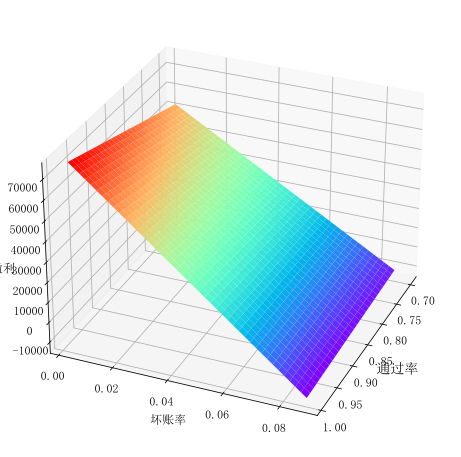

In [32]:
# 画出利润曲线图
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

m = 1000000
p = 0.08

t = np.arange(0.7,0.99,0.01)
h = np.arange(0.003,0.088,0.001)

fig = plt.figure()
fig = plt.figure(figsize=(8, 8))
# fig = plt.figure(figsize=(10, 8))
ax3 = plt.axes(projection='3d')

#定义三维数据
t = np.arange(0.7,0.99,0.01)
h = np.arange(0.003,0.088,0.001)
# X和Y轴 作用是从给定的一维数组t和h创建一个二维坐标网格。生成的X和Y数组具有相同的形状，并包含t和h中对应元素的所有可能组合
X, Y = np.meshgrid(t, h)

# 利息
Z = m*X*(p-(1+p)*Y)

#作图
ax3.plot_surface(X,Y,Z,cmap='rainbow')
# 作图
#ax3.plot_trisurf(X.flatten(), Y.flatten(), Z.flatten(), cmap='rainbow')

ax3.set_xlabel('通过率',fontsize=14) #X
ax3.tick_params(axis='x', labelsize=12)
ax3.set_ylabel('坏账率') #Y
ax3.set_zlabel('盈利')#Z
#elev参数表示从水平面看垂直方向的旋转角度，azim参数表示从xz平面看x轴正半轴的旋转角度
ax3.view_init(elev=29, azim=23)
# plt.tight_layout()
#plt.savefig('./figs/w-t_h.png',dpi=800)

这个时候我们能很明显的看出不同的通过率坏账率组合对应的盈利，然后将题目所给表的数据代入计算即可。

In [33]:
df.head(3)

,Card1,Card2,Card3,Card4,Card5,Card6,Card7,Card8,Card9,Card10,...,Card91,Card92,Card93,Card94,Card95,Card96,Card97,Card98,Card99,Card100
1,"[0.76, 0.013]","[0.72, 0.032]","[0.8, 0.012]","[0.79, 0.004]","[0.7, 0.009]","[0.7, 0.033]","[0.73, 0.016]","[0.79, 0.01]","[0.75, 0.01]","[0.73, 0.012]",...,"[0.76, 0.004]","[0.76, 0.012]","[0.81, 0.016]","[0.75, 0.004]","[0.71, 0.009]","[0.74, 0.006]","[0.72, 0.023]","[0.79, 0.011]","[0.75, 0.011]","[0.71, 0.016]"
2,"[0.77, 0.015]","[0.73, 0.038]","[0.82, 0.013]","[0.8, 0.007]","[0.76, 0.015]","[0.71, 0.037]","[0.74, 0.021]","[0.88, 0.013]","[0.76, 0.011]","[0.74, 0.018]",...,"[0.8, 0.008]","[0.77, 0.013]","[0.83, 0.035]","[0.77, 0.014]","[0.72, 0.015]","[0.76, 0.017]","[0.77, 0.037]","[0.81, 0.015]","[0.77, 0.013]","[0.78, 0.024]"
3,"[0.78, 0.017]","[0.76, 0.05]","[0.83, 0.024]","[0.81, 0.011]","[0.77, 0.025]","[0.73, 0.042]","[0.75, 0.022]","[0.89, 0.016]","[0.78, 0.015]","[0.76, 0.019]",...,"[0.85, 0.016]","[0.78, 0.016]","[0.84, 0.042]","[0.78, 0.018]","[0.73, 0.049]","[0.8, 0.04]","[0.8, 0.043]","[0.83, 0.023]","[0.8, 0.02]","[0.8, 0.028]"


可以看出，选用第49张信用评分卡且使用第一档阈值时（t=0.82,h=0.005），其最终收入最多，最终收入为61172。

## 问题一【QUBO解法】（题目指定）

In [34]:
def fun2(x,y):
    return m*x*(p-(1+p)*y) #Z = m*X*(p-(1+p)*Y) = 利息
# sourcery skip: use-itertools-product

Data = []
for j in range(1,101):#100个评分信用卡
    for i in range(1,11):#每张评分信用卡里面有十个t和h
        th = df.iloc[i-1,j-1]#每次内循环之后，都会获取每一个组合的所有数据,比如第一次内循环会获取第一个信用评分卡的组合数据
        Data.append([j,i]+th)#[0,0]+th = [0,0,0.76,0.013] #规范数据格式[‘评分卡序号’,'阈值','通过率','坏账率']
df_w = pd.DataFrame(Data,columns=['Card','Threshold','t','h'])#把所有数据以此格式放入df_w中,并转为DataFrame格式(DataFrame是一种二维的数据结构，类似于电子表格或SQL表格)
print(df_w)
'''
df_w.apply(lambda x: fun2(x[2],x[3]),axis=1)的作用是对DataFrame的每一行应用函数fun2，计算并返回相应的结果。其中，
lambda x: fun2(x[2],x[3])定义了一个匿名函数，它接受一个Series对象x（代表DataFrame的一行数据），
并返回fun2函数对x的第3个和第4个元素（即't'和'h'列）进行计算的结果。axis=1参数指定对每一行应用函数，而不是对每一列应用函数。

具体来说，该代码会在df_w的每一行上计算't'和'h'列的值，将它们作为参数传递给函数fun2，然后将fun2的返回值赋值给'w'列。
这样，DataFrame中的每一行都将包含一个名为'w'的新列，其值是根据't'和'h'列计算得出的盈利结果。
'''
df_w['w'] = df_w.apply(lambda x: fun2(x[2],x[3]),axis=1)#定义df_w['w']，w作为标签，代表盈利的意思,

'''
作用是对DataFrame对象df_w中的数据按照'w'列进行降序排列，即将'w'列的值从大到小排序。其中，sort_values()函数是Pandas库中用于排序的函数，参数'w'指定了按照'w'列进行排序，
ascending=0表示降序排列，ascending=1则表示升序排列。
'''
df_w = df_w.sort_values('w',ascending=0)
df_w.iloc[0:10]

     Card  Threshold     t      h
0       1          1  0.76  0.013
1       1          2  0.77  0.015
2       1          3  0.78  0.017
3       1          4  0.80  0.024
4       1          5  0.82  0.026
..    ...        ...   ...    ...
995   100          6  0.86  0.052
996   100          7  0.87  0.053
997   100          8  0.88  0.064
998   100          9  0.90  0.069
999   100         10  0.91  0.084

[1000 rows x 4 columns]


,Card,Threshold,t,h,w
480,49,1,0.82,0.005,61172.0
481,49,2,0.83,0.006,61021.6
30,4,1,0.79,0.004,59787.2
531,54,2,0.78,0.004,59030.4
482,49,3,0.85,0.010,58820.0
720,73,1,0.82,0.008,58515.2
151,16,2,0.78,0.005,58188.0
721,73,2,0.84,0.010,58128.0
71,8,2,0.88,0.013,58044.8
31,4,2,0.80,0.007,57952.0


In [35]:
print(datas)

[0.76, 0.013, 0.72, 0.032, 0.8, 0.012, 0.79, 0.004, 0.7, 0.009, 0.7, 0.033, 0.73, 0.016, 0.79, 0.01, 0.75, 0.01, 0.73, 0.012, 0.75, 0.007, 0.71, 0.012, 0.8, 0.012, 0.75, 0.006, 0.72, 0.027, 0.71, 0.003, 0.72, 0.012, 0.79, 0.015, 0.77, 0.008, 0.7, 0.034, 0.77, 0.006, 0.7, 0.016, 0.81, 0.016, 0.75, 0.009, 0.7, 0.015, 0.73, 0.003, 0.72, 0.015, 0.8, 0.013, 0.75, 0.014, 0.71, 0.013, 0.75, 0.022, 0.7, 0.012, 0.8, 0.009, 0.76, 0.013, 0.7, 0.009, 0.7, 0.005, 0.74, 0.015, 0.8, 0.012, 0.75, 0.008, 0.71, 0.018, 0.81, 0.01, 0.7, 0.013, 0.8, 0.015, 0.77, 0.006, 0.7, 0.01, 0.71, 0.011, 0.72, 0.017, 0.79, 0.028, 0.82, 0.005, 0.7, 0.016, 0.77, 0.018, 0.7, 0.02, 0.8, 0.011, 0.75, 0.003, 0.75, 0.008, 0.73, 0.007, 0.72, 0.015, 0.81, 0.019, 0.79, 0.01, 0.7, 0.021, 0.76, 0.007, 0.7, 0.008, 0.84, 0.017, 0.75, 0.005, 0.7, 0.012, 0.7, 0.007, 0.75, 0.014, 0.8, 0.009, 0.77, 0.005, 0.7, 0.009, 0.75, 0.012, 0.72, 0.019, 0.82, 0.008, 0.75, 0.003, 0.71, 0.011, 0.7, 0.007, 0.73, 0.02, 0.8, 0.011, 0.75, 0.005, 0.71, 

In [36]:
unique_t = {i for i in datas if i >0.5}
unique_h = {i for i in datas if i <0.5}
len(unique_t),len(unique_h) # 这里取值分别为30，86个，意味着我们最后需要将这两个变量转化为116个二元变量
print(unique_t)
print(unique_h)

{0.76, 0.72, 0.79, 0.8, 0.7, 0.73, 0.75, 0.71, 0.77, 0.81, 0.84, 0.92, 0.85, 0.93, 0.94, 0.91, 0.86, 0.78, 0.95, 0.87, 0.96, 0.88, 0.97, 0.89, 0.98, 0.82, 0.9, 0.74, 0.99, 0.83}
{0.087, 0.081, 0.075, 0.079, 0.071, 0.073, 0.077, 0.085, 0.083, 0.065, 0.059, 0.061, 0.063, 0.067, 0.069, 0.053, 0.051, 0.057, 0.055, 0.049, 0.045, 0.043, 0.047, 0.037, 0.039, 0.041, 0.033, 0.031, 0.035, 0.027, 0.029, 0.023, 0.025, 0.019, 0.021, 0.015, 0.017, 0.013, 0.011, 0.009, 0.007, 0.005, 0.003, 0.086, 0.088, 0.072, 0.076, 0.074, 0.084, 0.082, 0.08, 0.078, 0.062, 0.064, 0.066, 0.06, 0.068, 0.07, 0.052, 0.056, 0.058, 0.054, 0.046, 0.05, 0.044, 0.048, 0.038, 0.042, 0.036, 0.04, 0.032, 0.034, 0.03, 0.028, 0.026, 0.022, 0.024, 0.018, 0.02, 0.016, 0.014, 0.012, 0.01, 0.008, 0.006, 0.004}


In [37]:
# 生成alpha和beta的数据
alpha = unique_t
beta = unique_h

# # 将t取值平均分成30份，保存在列表alpha中
# for i in range(30):
#     alpha_val = 0.7 + i * 0.01
#     alpha += [alpha_val] * 100
#
# # 将h取值平均分成86份，保存在列表beta中
# for i in range(86):
#     beta_val = 0.003 + i * 0.008
#     beta += [beta_val] * 100
#
# # 打印alpha和beta数据的长度
# print("alpha:",alpha)
# print("beta:",beta)
# print(len(alpha), len(beta))
print(alpha)
print(beta)


{0.76, 0.72, 0.79, 0.8, 0.7, 0.73, 0.75, 0.71, 0.77, 0.81, 0.84, 0.92, 0.85, 0.93, 0.94, 0.91, 0.86, 0.78, 0.95, 0.87, 0.96, 0.88, 0.97, 0.89, 0.98, 0.82, 0.9, 0.74, 0.99, 0.83}
{0.087, 0.081, 0.075, 0.079, 0.071, 0.073, 0.077, 0.085, 0.083, 0.065, 0.059, 0.061, 0.063, 0.067, 0.069, 0.053, 0.051, 0.057, 0.055, 0.049, 0.045, 0.043, 0.047, 0.037, 0.039, 0.041, 0.033, 0.031, 0.035, 0.027, 0.029, 0.023, 0.025, 0.019, 0.021, 0.015, 0.017, 0.013, 0.011, 0.009, 0.007, 0.005, 0.003, 0.086, 0.088, 0.072, 0.076, 0.074, 0.084, 0.082, 0.08, 0.078, 0.062, 0.064, 0.066, 0.06, 0.068, 0.07, 0.052, 0.056, 0.058, 0.054, 0.046, 0.05, 0.044, 0.048, 0.038, 0.042, 0.036, 0.04, 0.032, 0.034, 0.03, 0.028, 0.026, 0.022, 0.024, 0.018, 0.02, 0.016, 0.014, 0.012, 0.01, 0.008, 0.006, 0.004}


QUBO介绍

QUBO 模型是指二次无约束二值优化（Quadratic Unconstrained Binary Optimization）模型

它是一种用于解决组合优化问题的数学模型

在QUBO模型中，需要将问题转化为一个决策变量为二值变量，目标函数是一个二次函数形式优化模型

首先，需要将原始的两个自变量t、h，分别转换为二元变量

t：（30个取值，从0.7，每隔0.01，到0.99）

h：（86个取值，从0.003，每隔0.008，到0.088）

原理如下：班级取值有1，2，3班，将这个变量分解为三个变量x1,x2,x3，如果是1班，那么对应取值为100，如果是3班，对应取值为001，其他的类推。

但是30×86>10×100，这使得最后的结果（t、h的组合并不在100张评分表中），所以意味着我们最后可能需要将这两个变量用1000个二元变量来表示（表的数量100*阈值的个数10）

假定我们选取的是第j张信用表的第i个阈值，$x_{ij}=1，x_{mn}=0(m\neq i,n\neq j)$

$x_{ij}$对应的t系数取其原有的数值记为$\alpha_{ij}$，对应的h系数取其原有的数值记为$\beta_{ij}$


此时我们原生的两个变量可写为
$$ t = \sum \sum{\alpha_{ij} x_{ij}} $$
$$ h = \sum \sum{\beta_{ij} x_{ij}} $$

又最终收入为：$\omega = I-L = Mpt(1-h)-Mth = Mt(p-(1+p)h)$

不考虑M的影响，等价于最大化下面的式子
$$ Max(Z) = t(p-(1+p)h) = (\sum \sum{\alpha_{ij} x_{ij}}) \cdot (p-(1+p) \cdot (\sum \sum{\beta_{ij} x_{ij}})) $$
其中，自变量为$x_{ij} \in \{0,1\}, i\in [1,10],j \in [1,100]$且
$$ \sum \sum{x_{ij}}=1$$

或将约束加入目标：（通过添加约束项，并设置较大的系数P保证约束内容的优先级）
$$ Max(Z^{'}) = (\sum \sum{\alpha_{ij} x_{ij}}) \cdot (p-(1+p) \cdot (\sum \sum{\beta_{ij} x_{ij}})) - P(\sum \sum{x_{ij}})^2$$

此时，我们已经将问题转化为二元问题了，下面将此问题利用QUBO编程求解即可。

In [38]:
import numpy as np
from scipy.optimize import minimize

# 将原始的两个自变量 t、h，分别转换为二元变量
t_values = np.arange(0.7, 0.99, 0.01)
h_values = np.arange(0.003, 0.089, 0.008)
# print(t_values)
t_binary_values = np.zeros((len(t_values), len(h_values)), dtype=int)
h_binary_values = np.zeros((len(t_values), len(h_values)), dtype=int)

print(h_binary_values)

for i, t in enumerate(t_values):
    for j, h in enumerate(h_values):
        # 将班级取值分解为三个变量 x1, x2, x3
        x1 = int(np.floor((i / 10) % 10))
        x2 = int(np.floor(i / 100))
        x3 = int(np.floor(j / 10))

        # 将班级取值转换为二元变量
        t_binary_values[i, j] = x1 * 100 + x2 * 10 + x3
        h_binary_values[i, j] = int((j % 10) / 5)

# 选取第 j 张评分表的第 i 个阈值
def objective_function(x, t_values, h_values, p):
    alpha = np.array(t_values).reshape(-1, 1)
    beta = np.array(h_values).reshape(-1, 1)
    x = x.reshape(alpha.shape)
    t = np.sum(alpha * x)
    h = np.sum(beta * x)
    return -t * (p - (1 + p) * h)

# 添加约束条件
def constraint(x):
    return np.sum(x) - 1

constraints = [{'type': 'eq', 'fun': constraint}]

# 最大化目标函数
p = 1.0  # 未考虑 M 的影响
x0 = np.ones(t_binary_values.size) / t_binary_values.size  # 初始化 x
res = minimize(objective_function, x0, args=(t_binary_values, h_binary_values, p),
               method='SLSQP', constraints=constraints)

# 输出最优解和最优值
x_opt = res.x.reshape(t_binary_values.shape)
t_opt = np.sum(t_binary_values * x_opt)
h_opt = np.sum(h_binary_values * x_opt)
omega = t_opt * (p - (1 + p) * h_opt)
print('最优解 x：\n', x_opt)
print('最优值 Z\'：', -res.fun)
print('t 的值：', t_opt)
print('h 的值：', h_opt)
print('omega 的值：', omega)

[[0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]]


C:\Users\lenovo\AppData\Local\Temp\ipykernel_20404\3792999295.py:31: RuntimeWarning: overflow encountered in double_scalars
  return -t * (p - (1 + p) * h)
C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


最优解 x：
 [[nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan

In [39]:
# neal是模拟退火的库
import neal
# pyqubo 可以使用Binary定义变量，Constarint定义约束
from pyqubo import Binary, Constraint
x1, x2 = Binary('x1'), Binary('x2')

# M是约束强度
# P = M，约束条件为()
M = 5.0
#定义哈密顿算符H
H = 3 * x1**2 - 2 * x2**2 + M * Constraint((x2 - x1*x2), label='x1>=x2')
model = H.compile()

# 无视offset就行了，QUBO用来做模拟退火的输入
qubo, offset = model.to_qubo()
sampler = neal.SimulatedAnnealingSampler()
raw_solution = sampler.sample_qubo(qubo)

raw_solution.first.sample

{'x1': 0, 'x2': 0}

## 问题二【QUBO解法】

此时，相对于第一问，这里增加了两张评分卡，仅需要将三个评分卡的总通过率和坏账率计算出来，然后带入第一问的模型即可。

首先，已经确定是使用的123张评分卡，那么$j_1,j_2,j_3=1,2,3$

假定三个评分卡选取的阈值依次是第$i_1,i_2,i_3 \in [1,10]$，$x_{i_k j_k}=1，x_{mn}=0(m\neq i_k,n\neq j_k),k=\{1,2,3\}$

$x_{i j}$对应的t系数取其原有的数值记为$\alpha_{i j}$，对应的h系数取其原有的数值记为$\beta_{i j}$

可知
$$ t_{j_k} = \sum_{i=1}^{10}{\alpha_{i,j_k} x_{i,j_k}}, k=1,2,3$$
$$ t = t_{j_1}t_{j_2}t_{j_3} = \sum_{i=1}^{10}{\alpha_{i,j_1} x_{i,j_1}} \cdot \sum_{i=1}^{10}{\alpha_{i,j_2} x_{i,j_2}} \cdot \sum_{i=1}^{10}{\alpha_{i,j_3} x_{i,j_3}}$$
$$ h_{j_k} = \sum_{i=1}^{10}{\beta_{i,j_k} x_{i,j_k}}, k=1,2,3$$
$$ h = (\sum_{k=1}^{3} h_{j_k})/3 = (\sum_{k=1}^{3} \sum_{i=1}^{10}{\beta_{i,j_k} x_{i,j_k}})/3$$

又最终收入为：$\omega = I-L = Mpt(1-h)-Mth = Mt(p-(1+p)h)$

不考虑M的影响，等价于最大化下面的式子
$$ Max(Z) = t(p-(1+p)h)$$

同理上问，下面将此问题利用QUBO编程求解即可。（但是这里其实有个问题，因为根据题目所说的，总通过率是按三者乘积，这导致最后的目标成了四次多项式，而QUBO是针对2次的，这个问题大家自己看看怎么解决吧，第三问就用将这里的$j_1,j_2,j_3 \in [1,100]$即可）

为了解决这个问题，我们可以使用整数线性规划模型。假设有 $n$ 张信用评分卡，其中第 $i$ 张评分卡的评分为 $s_i$，其对应的阈值为 $t_i$，每张评分卡可以被选择或不被选择，我们可以使用 $x_i$ 表示第 $i$ 张评分卡是否被选择，其中 $x_i \in {0,1}$。假设最终收入为 $r(x_1, x_2, ..., x_n)$，则最大化收入的目标函数可以表示为：
max∑i=1nr(x1,x2,...,xn)x
其中，$r(x_1, x_2, ..., x_n)$ 是一个非线性函数，它表示在选择了第 $i$ 张评分卡的情况下，最终收入的值。在这里，我们可以使用一个分段线性函数来近似表示 $r(x_1, x_2, ..., x_n)$，使其变为一个线性函数，如下所示：
r(x1,x2,...,xn)=∑i=1n(pi+qiti)xi−∑i=1nqit
其中 $p_i$ 和 $q_i$ 是常数，可以通过拟合实际数据得到。
考虑到最终收入的值受到多个评分卡的影响，我们还需要加入一些约束条件来确保解的有效性。首先，最终收入必须大于等于一个给定的最小值 $R_{\min}$。其次，每个阈值只能被选择一次，即：
∑i=1nxi=1
针对该问题，我们可以将整数线性规划模型转换为 QUBO 模型。QUBO 模型的目标函数和约束条件可以表示为：

其中 $\lambda$ 和 $\mu$ 是惩罚因子，用于确保约束条件的满足。$\max(0, R_{\min} - \sum_{i=1}^{n} r(x_1, x_2, ..., x_n) x_i)$ 保证最终收入不小于最小值 $R_{\min}$。
在 QUBO 模型中，$x_i$ 取值为 ${-1, 1}$，可以使用如下的等价式将其转换为二进制变量：
Step 2: 将目标函数转换为 QUBO 形式
在 QUBO 中，我们需要将目标函数转化为一系列二次项和一次项的组合，其中每个变量都是二进制的。因此，我们需要将目标函数中的所有变量都表示为二进制。
首先，我们可以将信用评分卡的得分分成几个离散的类别，并将每个类别分配给一个二进制变量。例如，我们可以将信用评分卡分成五个类别：
0 - 20 分: 变量 $x_1 = 1$
21 - 40 分: 变量 $x_2 = 1$
41 - 60 分: 变量 $x_3 = 1$
61 - 80 分: 变量 $x_4 = 1$
81 - 100 分: 变量 $x_5 = 1$
然后，我们可以将目标函数中的所有乘积转化为二次项。考虑到收入的计算方式，我们可以得到以下的目标函数：
f=20x1+40x2+60x3+80x4+100x5−T

其中，$a_i$ 是变量 $x_i$ 的二次项系数，$b_{ij}$ 是变量 $x_i$ 和 $x_j$ 的交叉项系数。注意到 $H$ 中没有一次项，因为我们可以通过将 $T$ 乘以 $-1$ 转换为二次项。
现在我们需要确定 $a_i$ 和 $b_{ij}$ 的值。由于我们希望信用评分卡得分越高，对应的 $f$ 值越大，因此我们可以设置 $a_i$ 为一个负值，即：
a1=−20,a2=−40,a3=−60,a4=−80,a5=−100
我们还需要确定 $b_{ij}$ 的值。由将目标函数和约束条件转换为 QUBO 形式后，我们可以使用现有的量子计算机或者量子计算机模拟器来求解 QUBO 模型。在这里，我们可以使用 D-Wave 的 Leap Quantum Cloud 服务来求解。


对于QUBO问题，需要将原始问题中的变量转换为二进制变量。一般地，将变量$x$用$N$个二进制变量表示：

$x=\sum_{i=0}^{N-1}2^i b_i$

其中，$b_i$为第$i$位的二进制变量，$b_i\in{0,1}$。这样，$x$的取值范围为$0$到$2^N-1$。对于QUBO问题，每个二进制变量对应一个相应的qubit。因此，可以将QUBO问题转化为qubit之间的关系。

例如，对于最大化目标函数$\max_x f(x)$，其中$x\in{0,1,2,\cdots,7}$，可以将$x$表示为一个3位二进制变量，即$x=4b_2+2b_1+b_0$。将其代入目标函数，得到：

$\max_{b_2,b_1,b_0} f(4b_2+2b_1+b_0)$

这样，可以将目标函数转化为三个二元变量$b_2,b_1,b_0$之间的关系。